# Routing and travel times

In [1]:
import multiprocessing as mp

import numpy as np
import osmnx as ox

np.random.seed(20250127)

In [2]:
# load local chapel hill street network data
G = ox.load_graphml('./data/network_ch.graphml')
Gp = ox.projection.project_graph(G)

In [3]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.convert.to_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [4]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.distance.nearest_nodes(Gp, X, Y, return_dist=True)

In [5]:
# find the nearest node to a single point
node = ox.distance.nearest_nodes(Gp, X0, Y0)
node

172698922

In [6]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.distance.nearest_edges(Gp, X, Y, return_dist=True)

In [7]:
# find the nearest edge to a single point
edge = ox.distance.nearest_edges(Gp, X0, Y0)
edge

(172698871, 172698922, 0)

## Basic routing by distance

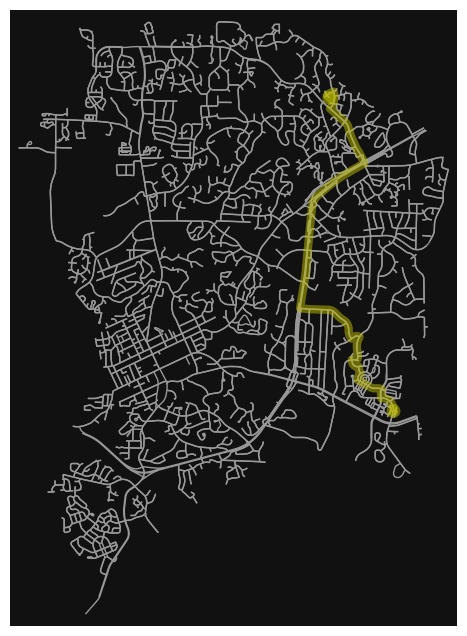

In [14]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[1500]
route = ox.routing.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

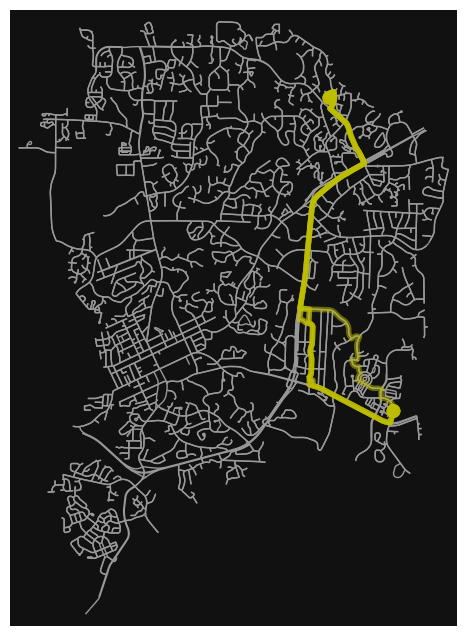

In [15]:
routes = ox.routing.k_shortest_paths(G, orig, dest, k=5, weight="length")
fig, ax = ox.plot.plot_graph_routes(
    G, list(routes), route_colors="y", route_linewidth=4, node_size=0
)

## Imputing travel speeds and times

In [16]:
# impute speed on all edges missing data
G = ox.routing.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.routing.add_edge_travel_times(G)

In [17]:
# see mean speed/time values by road type
edges = ox.convert.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
living_street,143.4,50.2,10.3
primary,175.3,54.9,11.4
primary_link,58.4,51.0,4.2
residential,141.6,39.6,13.0
secondary,176.2,53.3,12.1
secondary_link,144.1,40.2,12.9
tertiary,169.6,48.4,13.0
tertiary_link,23.4,50.2,1.7
trunk,289.9,70.3,15.1


In [18]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.routing.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.routing.add_edge_travel_times(G)

In [19]:
# calculate two routes by minimizing travel distance vs travel time
route1 = ox.routing.shortest_path(G, orig, dest, weight="length")
route2 = ox.routing.shortest_path(G, orig, dest, weight="travel_time")

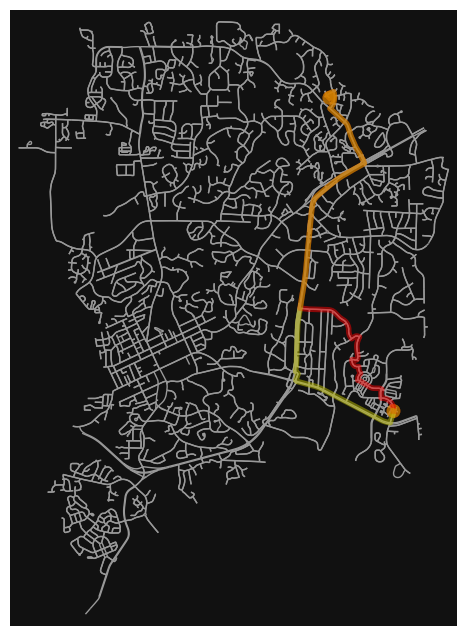

In [20]:
fig, ax = ox.plot.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [21]:
# compare the two routes
route1_length = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["length"]))
route2_length = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["length"]))
route1_time = int(sum(ox.routing.route_to_gdf(G, route1, weight="length")["travel_time"]))
route2_time = int(sum(ox.routing.route_to_gdf(G, route2, weight="travel_time")["travel_time"]))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 8360 meters and takes 583 seconds.
Route 2 is 8400 meters and takes 473 seconds.


## Multiprocessing

In [25]:
# calculate 10,000 shortest-path routes using random origin-destination pairs
n = 10000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [23]:
mp.cpu_count()

16

In [26]:
%%time
routes = ox.routing.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

CPU times: total: 45.3 s
Wall time: 51 s


In [27]:
%%time
routes = ox.routing.shortest_path(G, origs, dests, weight="travel_time", cpus=None)

CPU times: total: 8.73 s
Wall time: 14.8 s


In [28]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

10000
9910
